# Download Kaggle Dataset

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shayanfazeli/heartbeat")

print("Path to dataset files:", path)

100%|██████████| 98.8M/98.8M [00:00<00:00, 250MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/shayanfazeli/heartbeat/versions/1


In [4]:
# Check the path to dataset again
import os
os.listdir(path)

['mitbih_train.csv',
 'ptbdb_normal.csv',
 'ptbdb_abnormal.csv',
 'mitbih_test.csv']

# Import Libraries

In [8]:
!pip install -q imbalanced-learn

In [9]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Dataset

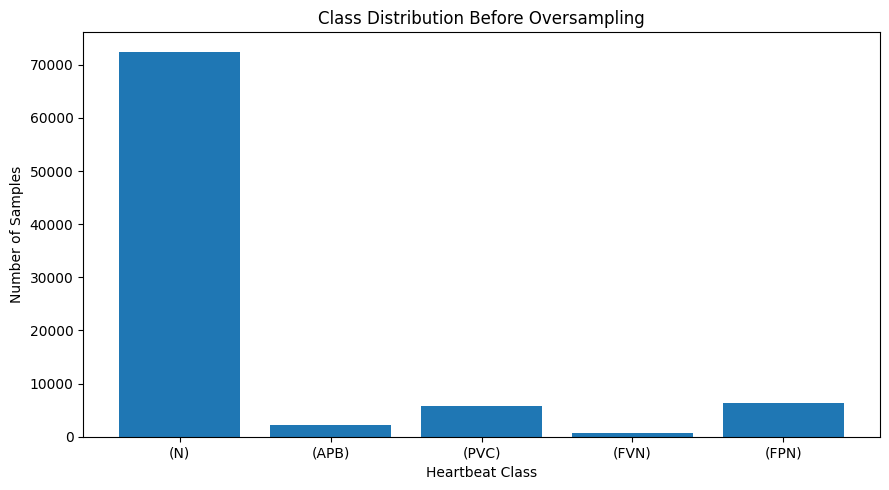

In [6]:
train_path = os.path.join(path, "mitbih_train.csv")
test_path = os.path.join(path, "mitbih_test.csv")

train = pd.read_csv(train_path, header=None)
test  = pd.read_csv(test_path, header=None)

X_train_raw = train.iloc[:, :-1].values
y_train_raw = train.iloc[:, -1].astype(int).values
X_test      = test.iloc[:, :-1].values
y_test      = test.iloc[:, -1].astype(int).values

class_names = {
    0: "(N)",
    1: "(APB)",
    2: "(PVC)",
    3: "(FVN)",
    4: "(FPN)"
}
classes, counts = np.unique(y_train_raw, return_counts=True)
labels = [class_names[c] for c in classes]
plt.figure(figsize=(9,5))
plt.bar(labels, counts)
plt.xlabel("Heartbeat Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before Oversampling")
plt.tight_layout()
plt.savefig("class_distribution_before_sampling.png", dpi=300, bbox_inches="tight")
plt.show()

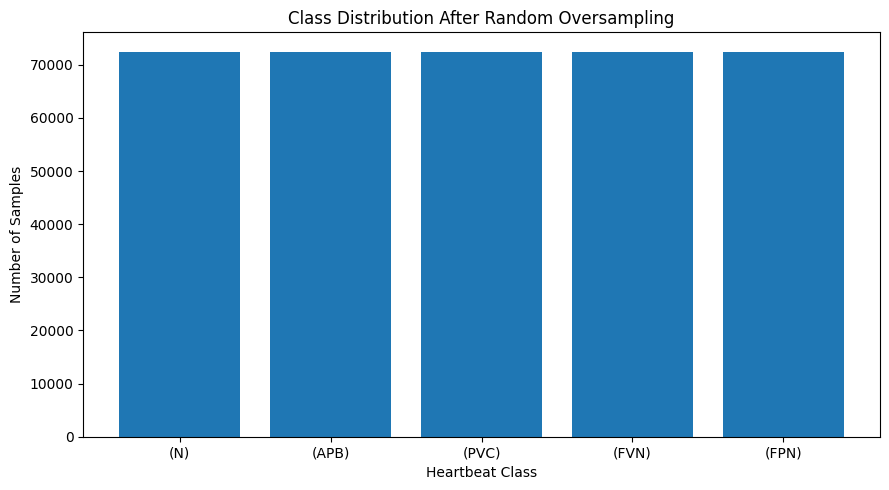

In [11]:
# Random Oversampler
ros = RandomOverSampler(random_state=42)
X_balanced, y_balanced = ros.fit_resample(X_train_raw, y_train_raw)

classes_bal, counts_bal = np.unique(y_balanced, return_counts=True)
labels = [class_names[c] for c in classes_bal]
plt.figure(figsize=(9,5))
plt.bar(labels, counts_bal)
plt.xlabel("Heartbeat Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Random Oversampling")
plt.tight_layout()
plt.savefig("class_distribution_after_sampling.png", dpi=300, bbox_inches="tight")
plt.show()

In [12]:
x_train, x_val, y_train, y_val = train_test_split(
    X_balanced, y_balanced, test_size=0.2, stratify=y_balanced, random_state=42
)

x_train = x_train.reshape(-1, 187, 1)
x_val   = x_val.reshape(-1, 187, 1)
X_test  = X_test.reshape(-1, 187, 1)

y_train = tf.keras.utils.to_categorical(y_train, num_classes=5)
y_val   = tf.keras.utils.to_categorical(y_val, num_classes=5)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=5)

# Model


In [13]:
# CNN–LSTM Model
model = Sequential([
    Input(shape=(187, 1)),
    Conv1D(64, 6, activation='relu'), BatchNormalization(), MaxPool1D(3, 2, padding="same"),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPool1D(2, 2, padding="same"),
    Conv1D(64, 3, activation='relu'), BatchNormalization(), MaxPool1D(2, 2, padding="same"),
    LSTM(64, return_sequences=True), LSTM(32),
    Flatten(),
    Dense(64, activation='relu'), Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
                    epochs=10, batch_size=32, callbacks=callbacks, verbose=1)

Epoch 1/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 146s 15ms/step - accuracy: 0.8750 - loss: 0.3462 - val_accuracy: 0.9624 - val_loss: 0.1102
Epoch 2/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 122s 13ms/step - accuracy: 0.9740 - loss: 0.0761 - val_accuracy: 0.9687 - val_loss: 0.0953
Epoch 3/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 139s 13ms/step - accuracy: 0.9851 - loss: 0.0460 - val_accuracy: 0.9882 - val_loss: 0.0367
Epoch 4/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 119s 13ms/step - accuracy: 0.9887 - loss: 0.0363 - val_accuracy: 0.9937 - val_loss: 0.0224
Epoch 5/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 119s 13ms/step - accuracy: 0.9911 - loss: 0.0284 - val_accuracy: 0.9930 - val_loss: 0.0236
Epoch 6/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 120s 13ms/step - accuracy: 0.9928 - loss: 0.0239 - val_accuracy: 0.9891 - val_loss: 0.0339
Epoch 7/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 129s 14ms/step - accuracy: 0.9938 - loss: 0.0201 - val_accuracy: 0.9832 - val_loss: 0.0582
Epoch 8/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 120s 13ms/step - accuracy: 

# Result

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step


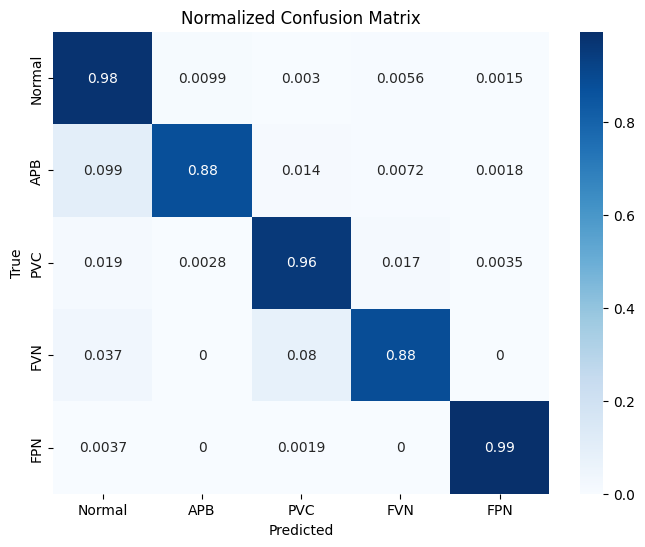

In [14]:
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_true_labels, y_pred_labels, normalize='true')
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=[
    'Normal', 'APB', 'PVC', 'FVN', 'FPN'
], yticklabels=[
    'Normal', 'APB', 'PVC', 'FVN', 'FPN'
])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.savefig("confusion_matrix2.png", dpi=300, bbox_inches="tight")
plt.show()